# Music Genre Classification using multiple classifiers
Team Members: Lisa Korntheuer, Jan Birkert, Adrian Desiderato, Jan Wangerin, Spyridon Spyropoulos

Imagine not knowing what genre you like. This notebook can help you find out what genre your song is! Never lose a genre-pub-quiz!


## Imports

In [41]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier
from scipy.stats import uniform, randint
import datetime as dt

# 0. Data understanding
Data describe (Features, Target etc.)
- filename and length irrelevant for ML
- 57 features -> PCA?
- only numerical data except for class labels ("label")

In [ ]:
df = pd.read_csv('./data/features_30_sec.csv')
df.info()

In [ ]:
df.head()

Correlations between features:

In [ ]:
cor = df.iloc[:, 2:-2].corr()
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(cor, square = True, xticklabels=True, yticklabels=True) 
plt.show()

Since there are quite a few feature combinations with high correlations, PCA may be worth a try. (See Data Prep)

## 1. Data preparation
Jan W.

Data splitting

y = LabelEncoder() 

MinMax()
Das andere() 


In [45]:
random_state = 0
LabelEnc = LabelEncoder()
y = df['label']
y = pd.DataFrame(LabelEnc.fit_transform(y))
df['label_enc'] = y

In [ ]:
scaler_mms = MinMaxScaler()

X = df.loc[:, 'chroma_stft_mean' : 'mfcc20_var']
X_scaled_array_mms = scaler_mms.fit_transform(X)

X_scaled_mms = pd.DataFrame(X_scaled_array_mms, columns=X.columns)

print(X)
print(X_scaled_mms)


PCA: (copied from Material Notebook 04, probably has to be adjusted later on)

To fight the curse of dimensionality, some dimensions could be removed, for example the last 12 to even 27 dimensions, since about 94% of "information" is contained in the first 30 PCs.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train_mms, X_test_mms, y_train_mms, y_test_mms = train_test_split(X_scaled_mms, y, test_size=0.2, random_state=0, stratify=y)

## 2. Model training 

Each Modell is trained and the quality of the classifier(accuracy) is displayed. 

### 2.1 Random Forests
Author: Spyridon S. 

In this section Random Forest as a classifier will be tested. In the first step all important libraries will be imported.

In [173]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree as tree

When training random forests, there is no heavy hyperparameter needed to get a good accuracy. The structure of the model is already decreasing Bias and Variance by injecting randomness on constructing the trees. By Random Feature selection and Bagging the Risk of Overfitting is minimized, and by slightly tuning the hyperparameters, the Underfitting risk is also minimized. Nevertheless, we will perform a soft hyperparameter tuning, as well as a heavy hyperparameter tuning. The aim is to see if it makes sense to preform a heavy hyperparameter tuning.

#### 2.1.1 Simple Hyperparameter tuning 
It is enough only to tune the numbers of trees in the ensemble "n_estimators" and the splitting criterion. All other hyperparameters will use the default values. 

In [175]:

rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)
param_grid = {'n_estimators': np.array([ 100, 250, 500, 1000, 2000, 7000]), 
              'criterion':['gini','entropy', 'log_loss'],
              }
grid_search_rf_simple = GridSearchCV(rf, param_grid, n_jobs=-1, cv=2, scoring='accuracy', verbose=1, refit=True)
start = dt.datetime.now()
grid_search_rf_simple.fit(X_train_mms, y_train_mms.values.ravel()) # MinMaxScaler is not really needed for Random Forest, but we are using it to be consistent with other models
end = dt.datetime.now()
print(f"Training for MinMaxScaler data took {end - start}")
y_pred_rf_simple = grid_search_rf_simple.predict(X_test_mms)


Fitting 2 folds for each of 18 candidates, totalling 36 fits
Training for MinMaxScaler data took 0:00:18.773309


The GridSearch found out the best model, the results: 

In [ ]:
grid_search_rf_simple.score(X_test_mms, y_test_mms)
print("Best Score: %f" % grid_search_rf_simple.best_score_)
print("Optimal Hyperparameter Values: ", grid_search_rf_simple.best_params_)
print("Optimal Model: ", grid_search_rf_simple.best_estimator_)
accuracy_rf_simple = accuracy_score(y_test_mms, y_pred_rf_simple)
print(f"Accuracy: {accuracy_rf_simple}")

So in ~20 seconds (on my machine), Gridsearch found a model with 76% accuracy. That's a really good result! 

#### 2.1.2 Heavy Hyperparameter tuning

But let's also try some heavy hyperparameter tuning to see what results can be achieved: (This takes some time.... ~20min.) 

In [ ]:

rf_heavy = RandomForestClassifier(random_state=random_state, n_jobs=-1)
param_grid_rf_heavy = {'n_estimators': np.array([ 100, 250, 500, 1000, 2000, 7000]), 
              'criterion':['gini','entropy', 'log_loss'],
              'max_depth': np.array([3,5, 7,10, None]),
                'min_samples_split': np.array([2, 5, 10]),
                'min_samples_leaf': np.array([1, 2, 4]),
                'max_features': np.array(['sqrt', 'log2'])
              }
grid_search_rf_heavy = GridSearchCV(rf_heavy, param_grid_rf_heavy, n_jobs=-1, cv=2, scoring='accuracy', verbose=1, refit=True)
start = dt.datetime.now()
grid_search_rf_heavy.fit(X_train_mms, y_train_mms.values.ravel())
end = dt.datetime.now()
print(f"Training for MinMaxScaler data took {end - start}")
y_pred_heavy = grid_search_rf_heavy.predict(X_test_mms)

Now that needed a lot of time. It took nearly 20 minutes to get the results. Hopefully the created model is better:

In [ ]:
grid_search_rf_heavy.score(X_test, y_test)
print("Best Score: %f" % grid_search_rf_heavy.best_score_)
print("Optimal Hyperparameter Values: ", grid_search_rf_heavy.best_params_)
print("Optimal Model: ", grid_search_rf_heavy.best_estimator_)
print(f"Accuracy: {accuracy_score(y_test, y_pred_heavy)}")

It is not... The score is greater, but the accuracy is worse.

#### 2.1.3 Best Random Forest

We see that with heavy hyperparameter tuning, that needed more than 15 minutes, the resulting forest is not really giving much more performance. There might be a better slightly better score of the found model, but the resulting accuracy of the model is worse. So our best Random Forest model is the following:

In [ ]:
rf_simple_best = grid_search_rf_simple.best_estimator_
rf_simple_best 

In the following the feature importance of the best random forest can be seen:

Feature ranking with names:


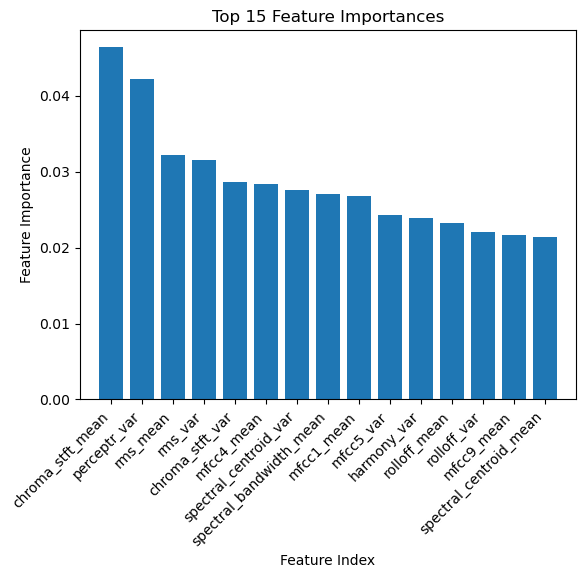

In [173]:
rf_simple_best = grid_search_rf_simple.best_estimator_

importances = rf_simple_best.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns


top_n = 15
top_indices = indices[:top_n]
top_importances = importances[top_indices]

top_feature_names = [feature_names[idx] for idx in top_indices]
print("Feature ranking with names:")


plt.figure()
plt.title(f"Top {top_n} Feature Importances")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_feature_names, rotation=45, ha='right')
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.xlim([-1, top_n])
plt.show()


### 2.2 Decision trees

Author: Jan W.

First try using post-pruning and the entire dataset. Post-pruning is done using hyperparameter-tuning with GridsearchCV.

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import tree

clf = DecisionTreeClassifier(random_state=random_state) #maybe use variable for random state so that all classifiers can be adjusted at the same time
path = clf.cost_complexity_pruning_path(X_train_mms, y_train_mms)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

plt.show()

In [ ]:
parameters = {'ccp_alpha':ccp_alphas[:-1].tolist()}
gs = GridSearchCV(DecisionTreeClassifier(random_state=random_state), parameters, cv=10, refit=True)
gs.fit(X_train_mms,y_train_mms)
tree_best = gs.best_estimator_
pred = tree_best.predict(X_test_mms)
print('Accuracy', accuracy_score(y_test_mms, pred))

In [ ]:
rules = export_text(tree_best, feature_names=X.columns)
print(rules)
print()
print("Feature importance:\n")
feature_importance = {}
i = 0
for col in X.columns:
    feature_importance[col] = tree_best.feature_importances_[i]
    i += 1
features_sorted = sorted(feature_importance.items(), key=lambda x : x[1])
features_sorted.reverse()
for feature in features_sorted:
    print(feature)

In [ ]:
fig = plt.figure(figsize=(10,10))
text = tree.plot_tree(tree_best, 
                   feature_names=X.columns.to_list(), 
                   filled=True)

plt.show()

Maybe try pre pruning with lower maximum height of tree, although that probably won't lead to better results. 

In [ ]:
cls = DecisionTreeClassifier(random_state=random_state)

params = {'max_depth':np.arange(3,15),
#          'min_samples_leaf':[3,5,10,15,20],
#          'min_samples_split':[8,10,12,18,20,16],
          'criterion':['gini','entropy']}
gs = GridSearchCV(cls, params, scoring='accuracy', cv=10, verbose=3, n_jobs=-1)
gs.fit(X_train_mms, y_train_mms)
params_optimal = gs.best_params_

print("Best Score: %f" % gs.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)

In [ ]:
tree_best = DecisionTreeClassifier(random_state=random_state, criterion='entropy', max_depth=11) #, min_samples_leaf=20, min_samples_split=8)
tree_best.fit(X_train_mms, y_train_mms)
pred = tree_best.predict(X_test_mms)
accuracy_dt = accuracy_score(y_test_mms, pred)
print('Test accuracy',accuracy_dt)

In [ ]:
fig = plt.figure(figsize=(10,10))
text = tree.plot_tree(tree_best, 
                   feature_names=X.columns.to_list(), 
                   filled=True)

plt.show()

Also try reduction of dimensions with PCA (only first 30 or so dimensions?)

### 2.3 KNN

Author: Lisa K.

Now the music genres are classified with the **k-Nearest Neighbors** algorithm. To enhance model performance, it can be useful to tune the following three hyperparameters via cross validation:
* ***n_neighbors***  :  number of neighbors $k$
* ***weights***  :  weights assigned to the nearest neighbors, especially relevant in case of ties
  - 'uniform'  :  all neighbors have equal weights
  - 'distance'  :  neighbors closer to the target point have higher weights
* ***metric***  :  method for distance computation
  - 'euclidean'  :  Euclidean distance
  - 'manhatten'  :  Manhatten distance

The first step is to define the possible values for each of these parameters in a dictionary.

In [62]:
# Define parameter combinations for hyperparameter tuning via cross validation 
params = {'n_neighbors': np.arange(1,20),               # parameter 'k' 
              'weights': ['uniform', 'distance'],       # parameter 'weights'
              'metric' : ['euclidean','manhattan']}     # parameter 'metric'

Then hyperparameter tuning is performed with the help of *GridSearchCV*, using 10-fold cross validation and accuracy as evaluation measure. The model is trained on the training data which have been normalized with the *MinMaxScaler*. Since kNN relies on distance measures, feature scaling is a necessary pre-processing step in this case.

In [ ]:

# Create KNN classifier
knn = KNeighborsClassifier()
# Use GridSearchCV to tune the chosen parameters
gs = GridSearchCV(knn, params, scoring='accuracy', cv=10, verbose=0, n_jobs=-1, refit=True)
# Train
gs.fit(X_train_mms, y_train_mms.values.ravel())    # Use training data scaled with MinMaxScaler

As can be seen from the optimal parameter set, choosing $k=3$ nearest neighbors, distance-dependent weights and Manhattan distance turns out to be the best combination in this experiment. Yet, it must be noted that distance-related weights are also computed if there are no ties, which might lead to overfitting.

In [ ]:
params_optimal = gs.best_params_

print("Best score: %f" % gs.best_score_)
print("Optimal hyperparameters: ", params_optimal)

Finally, this optimal classifier is taken to predict the music genres in the corresponding test set.

In [73]:
# Choose optimal classifier to predict
knn_optimal = gs.best_estimator_
y_pred_optimal = knn_optimal.predict(X_test_mms)

The evaluation shows that the tuned kNN model performs with an accuracy of 74% on these test data. 

In [ ]:
# Accuracy for tuned KNN
accuracy_knn = accuracy_score(y_test_mms, y_pred_optimal)
print('Accuracy:', accuracy_knn)  

### 2.4 Neural Networks - ANN

Authors: *Adrian Desiderato and Jan Birkert*

#### Hyperparameter Tuning and Model Training

To get the best possible result for an Artificial Neural Network, we want to tune our hyperparameters (the hidden layer sizes, the batch size, the activation function and the learning rate) beforehand. Since our dataset has only 1000 entries, let's attempt to use an approach similar to the one given in material notebook no. 10.

In [101]:
params = {
    'hidden_layer_sizes': [(randint.rvs(2, 200), randint.rvs(2, 200))],
    'activation': ['tanh', 'relu', 'logistic'],
    'alpha': [0.0001, 0.001, 0.05],
    'learning_rate_init': uniform(0.001, 0.01),
    'batch_size': randint(16, 128),
    'learning_rate': ['constant', 'adaptive', 'invscaling']
}

To get the best possible tuning, we will test with a combination of hyperparameters.

In [102]:
mlp = MLPClassifier(solver='adam',
                   max_iter=2000,
                   random_state=random_state)

clf_mms = RandomizedSearchCV(mlp, params, n_jobs=-1, cv=10)

As we prepared the data with the `MinMaxScaler`, let's use them.

In [ ]:
start = dt.datetime.now()
clf_mms.fit(X_train_mms, y_train_mms.values.ravel())
end = dt.datetime.now()
print(f"Training for MinMaxScaler data took {end - start}")


clf_mms

In [ ]:
pred_train_mms = clf_mms.predict(X_train_mms)
print('Train accuracy with MinMaxScaler:', accuracy_score(pred_train_mms, y_train_mms))
pred_test_mms = clf_mms.predict(X_test_mms)
print('Test accuracy with MinMaxScaler:', accuracy_score(pred_test_mms, y_test_mms))

After few tests, the best results were reached with: 

In [ ]:
ann_best_params = {'activation': 'relu',
 'alpha': 0.001,
 'batch_size': 63,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (70, 170),
 'learning_rate': 'invscaling',
 'learning_rate_init': 0.0014079058662580348,
 'max_fun': 15000,
 'max_iter': 2000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 0,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

ann_best = MLPClassifier(**ann_best_params)
ann_best.fit(X_train_mms, y_train_mms.values.ravel())
y_pred_ann = ann_best.predict(X_test_mms)
accuracy_ann = accuracy_score(y_test_mms, y_pred_ann)
print('Accuracy:', accuracy_ann)

As we can see, the data scaled with the `MinMaxScaler` yields the best result with a test accuracy of around 75%. Of course, as we used `randint` to randomize our hyperparameters for the number of neurons of the two hidden layers as well as the batch size, the accuracy will vary slightly each time the notebook is run. We also tested an ANN with a third hidden layer, which, however, did not improve the test accuracy for `MinMaxScaler` data.

## 3. Comparing Models 

In this section the resulting best models will be compared. Let's import needed libraries: 

In [165]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

As a first step, we create an array with the best models and their names: 

In [163]:
models = [knn_optimal, tree_best, rf_simple_best, ann_best]
model_names = ['KNN', 'Decision Tree', 'Random Forest', 'ANN']

### 3.1 Accuracy

Each Accuracy of the models will be showed here:

In [169]:
for model, name in zip(models, model_names): 
    y_pred = model.predict(X_test_mms)
    accuracy = accuracy_score(y_test_mms, y_pred)
    print(f"Accuracy of {name}: {accuracy}")

Accuracy of KNN: 0.74
Accuracy of Decision Tree: 0.525
Accuracy of Random Forest: 0.76
Accuracy of ANN: 0.77


It can be seen that ANNs have the best accuracy, followed by RFs and KNN. Decision Trees performed poorly here.

### 3.2 F1-Score

The F1-Score of all models will be calculated. 
The F1-Scores can be interpreted as follows: 

![image](https://images.prismic.io/encord/3b4efcda-c027-46d6-b4e1-02cad9ff5f48_image18.png?auto=compress,format)

In [170]:
# F1 score of each model
for model, name in zip(models, model_names): 
    y_pred = model.predict(X_test_mms)
    f1 = f1_score(y_test_mms, y_pred, average='weighted')
    print(f"F1 Score of {name}: {f1}")

F1 Score of KNN: 0.7430698080583664
F1 Score of Decision Tree: 0.5275499368033028
F1 Score of Random Forest: 0.7605592636233927
F1 Score of ANN: 0.7723010925648475


So depending on the table in KNN, RF and ANN had a good result. The result of Decision Trees was OK.

### 3.3 ROC, AUC Curve

A good comparison also can be made using the ROC-Curve of each model and the AUC. Due to the fact that ROC is designed for binary classifiers and our dataset contains 10 classes, we could create a ROC curve for each tuple of classes. But we decided to use a technique that averages the ROC-curves of all classes so that one ROC curve can be calculated for a multi-class classifier. 

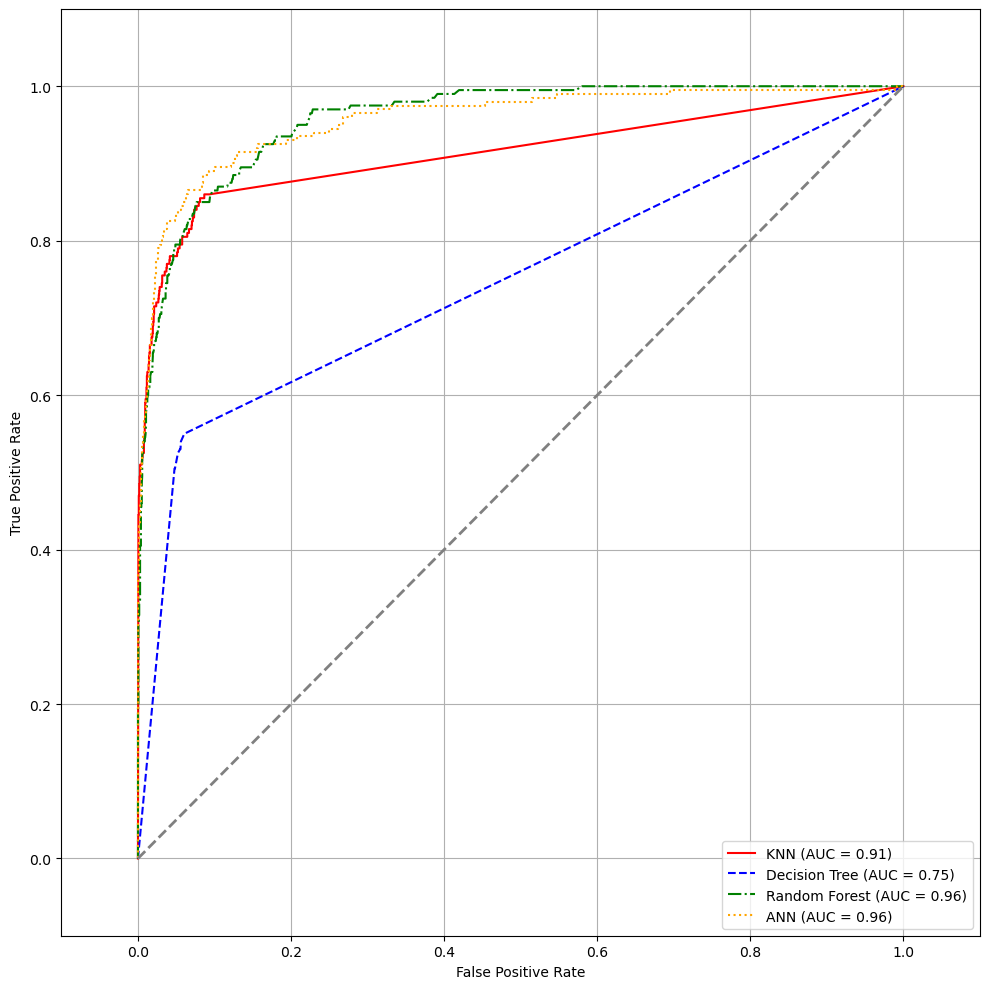

In [164]:
# We need to binarize the labels for the ROC curve
y_test_bin = label_binarize(y_test_mms, classes=np.unique(y))
y_train_bin = label_binarize(y_train_mms, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 10))
colors = ['red', 'blue', 'green', 'orange']
linestyles = ['-', '--', '-.', ':']
classifiers = models
labels = model_names

for clf, label, clr, ls in zip(classifiers, labels, colors, linestyles):
    classifier = OneVsRestClassifier(clf, n_jobs=-1)
    y_score = classifier.fit(X_train_mms, y_train_bin).predict_proba(X_test_mms)    
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (AUC = %0.2f)' % (label, roc_auc))


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)

plt.legend(loc='lower right')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
plt.show()

As can be seen from the ROC-graph, random forests and artificial neural networks have the best AUC. KNN is on third place and decision trees are last.

### 3.4 Comparison of models

In [154]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


model_entries = []
model_list = [
    ("KNN", knn_optimal),
    ("Decision Tree", tree_best),
    ("Random Forest", rf_simple_best),
    ("MLP", ann_best)
]

for model_name, model_obj in model_list:
    y_pred = model_obj.predict(X_test_mms)
    acc = accuracy_score(y_test_mms, y_pred)
    f1 = f1_score(y_test_mms, y_pred, average='weighted')
    classifier_ovr = OneVsRestClassifier(model_obj, n_jobs=-1)
    y_score = classifier_ovr.fit(X_train_mms, y_train_bin).predict_proba(X_test_mms)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc_val = auc(fpr, tpr)
    model_entries.append({
        "Model": model_name,
        "Accuracy": acc,
        "F1 Score (weighted)": f1,
        "ROC AUC (micro)": roc_auc_val
    })

comparison_df = pd.DataFrame(model_entries)
comparison_df.style.format(precision=3)

,Model,Accuracy,F1 Score (weighted),ROC AUC (micro)
0,KNN,0.740,0.743,0.913
1,Decision Tree,0.525,0.528,0.747
2,Random Forest,0.760,0.761,0.958
3,MLP,0.770,0.772,0.956


## 4. Summary and Conclusion


### 4.1 Summary
#### 4.1.1 Data Preparation and Scaling  
    
The dataset contains no null or infinity values. Also, all data is numerical, so no encoding is needed. Only the label was encoded, and the features were scaled using MinMaxScaler. 

#### 4.1.2 Model Training and Hyperparameter Tuning  
Each Model was trained on the same training dataset. On all models, hyperparameters were tuned so that better results can be achieved. For each model a small summary can be found in the following:
- Random Forest (RF)  
    - Used GridSearchCV for hyperparameter tuning, experimenting with different numbers of estimators and other parameters. 
    - The best model (rf_simple_best) was selected based on cross-validation accuracy.  
    - Feature importances were visualized to understand which input variables contributed most.
    - Also compared results of heavy/soft-hyperparameter-tuning and seen that soft-hyperparameter tuning resulted to better accuracy than heavy-hyperparameter tuning.   

- Decision Tree (DT)  
    - Demonstrated two techniques: post-pruning (via cost-complexity parameter ccp_alpha) and pre-pruning (via restricting max_depth).  
    - Used GridSearchCV to optimize parameters such as ccp_alpha, max_depth, and splitting criteria (e.g., “gini” vs. “entropy”).  
    - Visualized the resulting decision tree and extracted a text representation of its rules.  

- k-Nearest Neighbors (kNN)  
    - Tuned k (number of neighbors), weights (uniform or distance), and distance metric (e.g., Euclidean, Manhattan).  
    - After 10-fold cross validation, the best combination of hyperparameters was chosen, and predictions were made on the test set.  

- Artificial Neural Network (ANN, MLPClassifier)  
    - Used RandomizedSearchCV to explore hidden layer sizes, activation functions, batch size, and learning rate.  
    - Final chosen ANN model reached around 77% test accuracy.  

#### 4.1.3 Model Evaluation and Comparison  
The four main classifiers (KNN, Decision Tree, Random Forest, ANN) were compared on the test set and metrics included accuracy, F1 score (weighted), and ROC-AUC (micro-averaged for multi-class) were compared. A summary table was produced showing the performance of each best model.  



### 4.2 Conclusion  
Each of the four classifiers (KNN, Decision Tree, Random Forest, ANN) offered different trade-offs. There could be seen that decision trees seem to perform very poorly on this task, even with pruning the trees. Random Forest and ANN showed strong performance (accuracy around 77%), with kNN close behind. So for music classification, Random Forests, Artificial Neural Networks and K-Nearest-Neighbors can be used, but nearly $\frac{1}{4}$ of the predictions theoretically would be false. 

## 5. References 

- Machine Learning Lectures and Notebooks
- https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://scikit-learn.org/1.5/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
- https://scikit-learn.org/1.5/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
- https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
- https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html
- https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/
- https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://encord.com/blog/f1-score-in-machine-learning/#:~:text=Typically%2C%20an%20F1%20score%20%3E%200.9,to%20have%20a%20poor%20performance.
- 